In [2]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import rstoolbox
import pandas as pd
import seaborn as sns
import numpy as np
import copy

sns.set(font_scale=1.5)

# Evaluation of the effect of altering some score weights in NubInitioMover

Basically, we will check (separately) the effect of providing to the _MonteCarlo_ guiding the _ab initio_ process the following weights:  

## Binder Weights

```
abinitio->set_score_weight( core::scoring::interchain_pair,    mc_binder_weight_);
abinitio->set_score_weight( core::scoring::interchain_env,     mc_binder_weight_);
abinitio->set_score_weight( core::scoring::interchain_contact, mc_binder_weight_);
abinitio->set_score_weight( core::scoring::interchain_vdw,     mc_binder_weight_);
```

These weights were tested with the [nubinitio.xml](binder_weight/nubinitio.xml) script calling for different values on `mc_binder_weight_`. The different files obtained from those test are named as: `binder_weight_{weight}_silent.scores`.

## Angle and Dihedral constraint Weights
```
abinitio->set_score_weight( core::scoring::angle_constraint,    mc_angle_weight_ );
abinitio->set_score_weight( core::scoring::dihedral_constraint, mc_dihedral_weight_ );
```  
These weights were tested with the [nubinitio.xml](constraints_weight/nubinitio.xml) script calling for different values on `mc_angle_weight_` and `mc_dihedral_weight_` (the same in both at the same time). The different files obtained from those test are named as: `constraint_weight_{weight}_silent.scores`. These weights will all depend on previously using a __ConstraintGenerator__ that will add angle and dihedral constraints.


In [6]:
weights    = [ "0.0", "0.5", "1.0", "1.5", "2.0"]
experiment = ["binder", "constraint"]
file_name  = "{0}_weight/{0}_weight_{1}_silent.scores"

binder_definitions = {
    "scores":{
        "description": "description", "design_type": "weight", "design_score": "score", "ddg": "ddg"
    }
}
constraint_definitions = {
    "scores":{
        "description": "description", "design_type": "weight", "score": "score",
        "unf_angle": "unf_angle", "unf_atompair": "unf_atompair", "unf_dihedral": "unf_dihedral"
    }
}
df = {}
for e in experiment:
    dataframes = []
    definition = binder_definitions if e == "binder" else constraint_definitions
    for w in weights:
        dlist = rstoolbox.api.read_rosetta_silent(file_name.format(e, w), w)
        dataframes.append( rstoolbox.api.process_from_definitions(dlist, definition) )
    df[e] = pd.concat(dataframes)


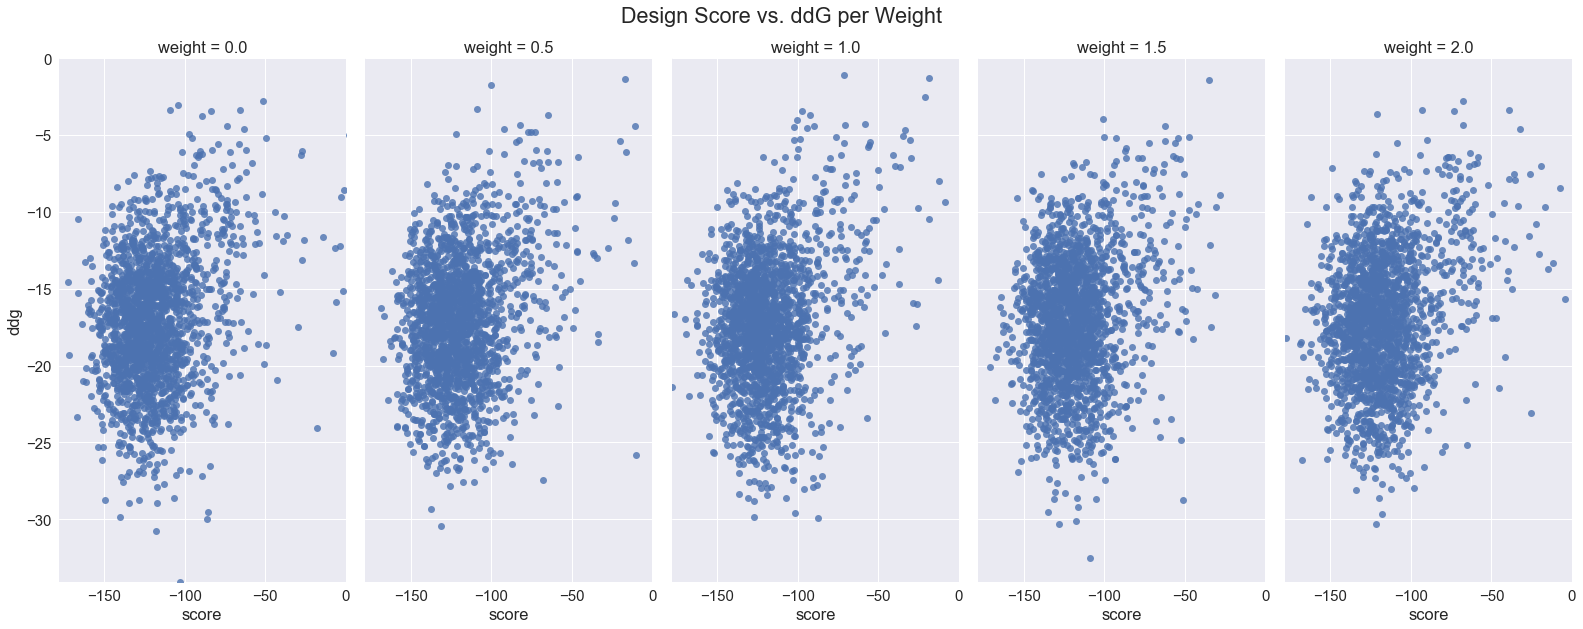

In [18]:
g = sns.FacetGrid(df["binder"], col="weight", size=9, aspect=0.5)
g = g.map(sns.regplot, "score", "ddg", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(min(df["binder"]["ddg"]), 0)
g.axes[0,0].set_xlim(min(df["binder"]["score"]), 0)
g.fig.suptitle('Design Score vs. ddG per Weight')
sns.plt.show()

In [20]:
def merge_types( df, keys ):
    dataframes = []
    for k in keys["split"]:
        colIDs = copy.copy(keys["keep"])
        colIDs.append(k[0])
        wdf = df[colIDs]
        wdf = wdf.assign(temporarykey1=pd.Series([k[1]]*len(wdf[colIDs[0]])).values).copy(True)
        wdf = wdf.rename(index=str, columns={
            k[0]: keys["names"][0],
            "temporarykey1": keys["names"][1]
        })
        if ( len(k) > 2 ):
            wdf = wdf.assign(temporarykey2=pd.Series([k[2]]*len(wdf[colIDs[0]])).values).copy(True)
            wdf = wdf.rename(index=str, columns={
                "temporarykey2": keys["names"][2]
            })
        dataframes.append(wdf)
    return pd.concat(dataframes)

In [31]:
logic = {
    "keep": ["description", "score", "weight"],
    "split": [("unf_angle", "angle"), ("unf_atompair", "pair") ],
    "names": ["unfulfilled", "cst_type"]
}
dfconstraints = merge_types( df["constraint"], logic)

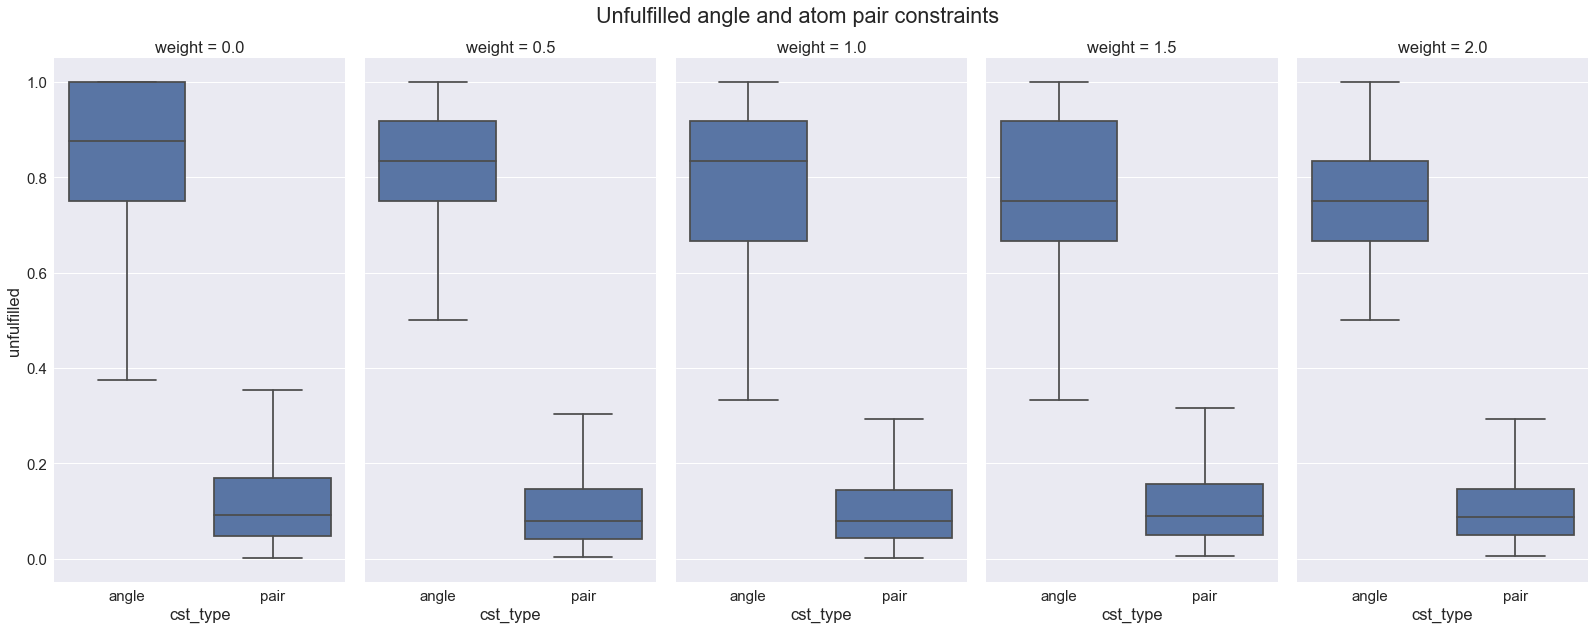

In [32]:
g = sns.FacetGrid(dfconstraints, col="weight", size=9, aspect=0.5)
g = g.map(sns.boxplot, "cst_type", "unfulfilled", showfliers=False)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Unfulfilled angle and atom pair constraints')
sns.plt.show()

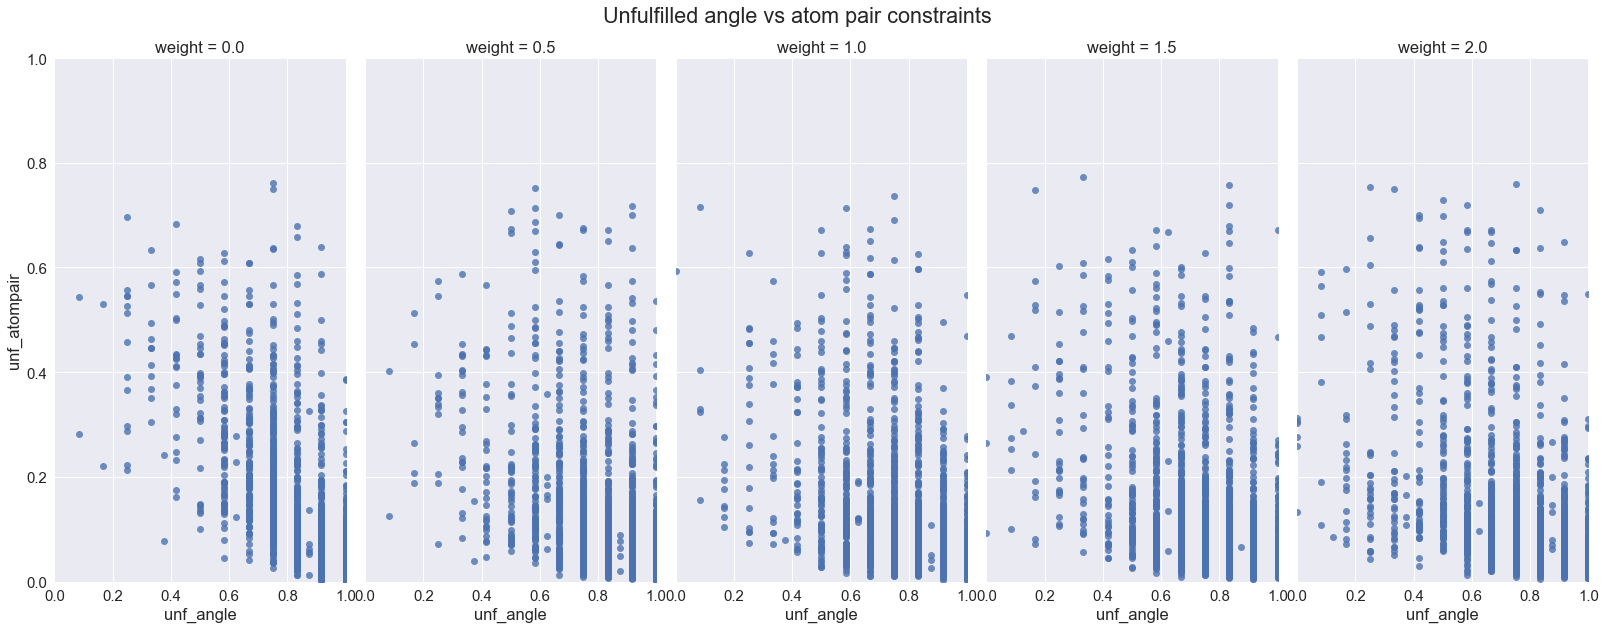

In [33]:
g = sns.FacetGrid(df["constraint"], col="weight", size=9, aspect=0.5)
g = g.map(sns.regplot, "unf_angle", "unf_atompair", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0, 1)
g.axes[0,0].set_xlim(0, 1)
g.fig.suptitle('Unfulfilled angle vs atom pair constraints')
sns.plt.show()